<a href="https://colab.research.google.com/github/jakobatgithub/unreverb/blob/main/STFT_AudioAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow STFT and STFT Inverse Layers


This notebook is based on [TensorFlow tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio#build_and_train_the_model). The tutorial is about dealing with Audio data, with the mini-speech command dataset. 

In the tutorial, the model consists of a CNN with the spectrogram of the audio as an input. Therefore, a preprocessing step is required to transform the audio waveform into a spectrogram via STFT. TensorFlow has the function `tf.signal.stft` for this. 

### Intro on STFT ([Wikipedia](https://en.wikipedia.org/wiki/Short-time_Fourier_transform))


###### Continous Time
Cut the time intervals into smaller windows, on each of these windows, you perform a FT on the signal. 

You end up with a series of FT along time. Meaning that the STFT function has two variables, one $\omega$ which represents a frequency, just like in normal FT and another, called $\tau$, which gives information about the window. 

In the continuous case, if for singal $x$, we call $\hat X$ the STFT of $x$:

$$ \hat X (\tau, \omega) = \int x(t) w(t - \tau) e^{-i \omega t} dt $$

##### Discrete time
In discrete settings, we will discretize time with variables $m, n$ and frequencies with variables $k$. 

$$\hat X (m, k) = \sum_n x_n w_{n-m} e^{-i k n}$$

##### Parameters

$w$ can simply be an indicator function. For example, with $s$ would be the "window size" of the STF: $ w(t) = \mathbb{1}_{t < s}$. \
However, there are many different window functions available ([and a dedicated wiki page](https://en.wikipedia.org/wiki/Window_function)). You basically can change the weights however you want. \
In the TF tutorial, the Hann window is used. 

You can also chose the frequencies to sample on. Usually, a `linspace` of $[0, \pi]$ is used. 


##### Spectrogram

The spectrogram of a time series $x$ is simply a module of the STFT. Hence, it is a function of two parameters and has non-negative values. We usually plot it as an image. \
The TF tutorial uses that image as input of a CNN to perform the classification. 
$$\text{spectrogram}(x)(m, k) = |X(m, k)|^2$$


##### STFT Inverse and Autoencoding
Like FT, the STFT has an inverse operation. The inverse operation can also be coded within the TensorFlow framework and backpropagated through. \
It allows us to have an easy test case for those two layers: autoencoded audio data into a spectrogram. This is done below

### Encoding STFT with a TF Layer


##### Idea
STFT operations are mainly matrix multiplication and summation. It can be implemented inside a NN. Also, nothing prevents us from backpropagating the gradients through the STFT operation. 

##### Possible Perks
- Learn which frequency are the most important in a datasets. Why bother discretizing $[0, \pi]$ with 1000 points if the results are good enough with 10 points. Important frequencies range depends on the task / dataset, eg. "outlier detection in engine noise" vs. "speech-to-text" 
- Learn a window function. The choice of the function is dependent on the application of the signal processing and usually a human made decision. [Wikipedia](https://en.wikipedia.org/wiki/Window_function#Choice_of_window_function)
- Backprop the gradients to signal preprocessing operations. Before the STFT, one could imagine implementing convolutions and applying backprop on those convolution weights. 
- (I didn't look into this yet but it might be possible to:) Accomodate the layer to make use of other signal processing mechanisms, eg. wavelet where you learn the wavelet funciton 

##### Drawbacks
The main drawback is that a TF STFT layer cannot be implemented using FFT. Therefore, the time of performing the operation can be much larger. If the number of frequencies used can be reduced, that could offset the lose of performance. Also, an STFT layer can be parallelized on the batch, mitigating the increase in complexity. And GPU is necessary to run this notebook in a reasonable time.  

In [1]:
!pip install torchaudio librosa boto3 tensorflow_io
!pip install pydub tensorflow_io

     |████████████████████████████████| 132 kB 4.7 MB/s 
     |████████████████████████████████| 23.4 MB 6.8 MB/s 
     |████████████████████████████████| 8.6 MB 12.8 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 127 kB 31.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the data

In [5]:
# !ls '/content/drive/My Drive/dsr_project/data/HarvardWordList/'
audiopaths = !ls '/content/drive/My Drive/dsr_project/data/Anechoic/'*'/mono/'*'.wav'
audiopaths = [x.replace("\'", "") for x in audiopaths]

irpaths = !ls '/content/drive/My Drive/dsr_project/data/samplicity-ir/'*'/'*'.wav'
irpaths = [x.replace("\'", "") for x in irpaths]

audiopaths
irpaths

['/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 2 Plates 12 Percussion Plate/2 Plates 12 Percussion Plate L.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 2 Plates 12 Percussion Plate/2 Plates 12 Percussion Plate  M-to-S.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 2 Plates 12 Percussion Plate/2 Plates 12 Percussion Plate R.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 3 Rooms 28 Front Room/3 Rooms 28 Front Room L.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 3 Rooms 28 Front Room/3 Rooms 28 Front Room  M-to-S.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 3 Rooms 28 Front Room/3 Rooms 28 Front Room R.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 4 Chambers 16 Amb Chamber B/4 Chambers 16 Amb Chamber B L.wav',
 '/content/drive/My Drive/dsr_project/data/samplicity-ir/M7 - 4 Chambers 16 Amb Chamber B/4 Chambers 16 Amb Chamber B  M-to-S.wav',
 '/c

In [ ]:
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
# import boto3
# from botocore import UNSIGNED
# from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

import torch
import torchaudio
import torchaudio.functional as F
import tensorflow as tf
from tensorflow.keras import layers
import torchaudio.transforms as T
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import pandas as pd



def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def my_get_sample(audiopath, resample=None):
  return _get_sample(audiopath, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  ir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return ir_raw, sample_rate
  rir = ir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def my_get_ir_sample(irpath, resample=None, processed=False):
  ir_raw, sample_rate = _get_sample(irpath, resample=resample)
  if not processed:
    return ir_raw, sample_rate
  ir = ir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  ir = ir / torch.norm(ir, p=2)
  ir = torch.flip(ir, [1])
  return ir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

# this is done here:
#   we load the audio data without reverb - the input
#   we load the impulse response (IR) functions
#   we generate the audio data with reverb by convolving all impulse response functions with all audio data without reverb
#   we transform all data to tensorflow datasets
#   one can solve two different tasks:
#     classification: which impulse response function is used
#     regression: remove the reverb from the input
#   correspondingly, we can generate two different datasets here:
#     one with the labels (consequtive numbers of the IRs) as the targets for classification
#     one with the audios without reverb as the targets (commented out)

# sampling rate for resampling
sample_rate = 8000

# all audio input should have the same length
# we split all audio data into chunks of length n
# n = 2*sample_rate corresponds to 2 seconds
# correspondingly, all audio data without reverb must be at least 2 seconds long
n = 2*sample_rate

# paths for audio without reverb


# paths to IR functions
# irpaths = [
#           #  "/content/drive/My Drive/dsr_project/data/r1-nuclear-reactor-hall/mono/r1_omni.wav", 
#            "/content/drive/My Drive/dsr_project/data/arthur-sykes-rymer-auditorium-university-york/b-format/s1r2.wav",
#            "/content/drive/My Drive/dsr_project/data/trollers-gill/b-format/dales_site1_1way_bformat.wav",
#            ]

# function to convolve IRs with audio
def my_convolve(ir, audio):
  audio_ = torch.nn.functional.pad(audio, (ir.shape[1]-1, 0))
  reverb_audio = torch.nn.functional.conv1d(audio_[None, ...], ir[None, ...])[0]
  return reverb_audio

# we number the IRs consecutively
unique_labels = [i for i in range(len(irpaths))]

# placeholder lists
irs = []
audios = []
reverb_audios = []
audio_chunks = []
reverb_audio_chunks = []
audio_chunks_2D = []
all_labels = []
labeled_reverb_audio_chunks = []

# loop over all audiofiles without reverb
for audiopath in audiopaths:
  # load audio without reverb 
  audio, _ = my_get_sample(audiopath, resample=sample_rate)
  print(f"audio.shape[1]: {audio.shape[1]}")

  # convert audio without reverb to numpy array
  #numpy_audio = audio.numpy()

  # collect alls audio without reverb in a list
  audios.append(audio)

  # split audio without reverb into chunks of length n
  audio_chunks_1D = []
  for j in range(0, audio.shape[1] - n, n):
    # a single audio chunk without reverb of length n
    audio_chunk = audio[:,j:j + n]
    
    # collect audio chunks without reverb in a list
    audio_chunks_1D.append(audio_chunk.numpy())
  
  # collect audio chunks without reverb in a 2D list
  audio_chunks_2D.append(audio_chunks_1D)


# we convolve all audios with all IRs
# counter for irpaths
iridx = 0
for irpath in irpaths:
  # load IR functions
  ir_raw, _ = my_get_ir_sample(irpath, resample=sample_rate)
  
  # shorten all IR functions to the same length
  ir = ir_raw[:, 0:int(sample_rate*1.5)]
  
  # renormalize IRs
  ir = ir / torch.norm(ir, p=2)
  
  # time reverse IRs
  ir = torch.flip(ir, [1])
  
  # collect IRs in a list
  irs.append(ir)
  
  # plot IRs
  #plot_waveform(ir, sample_rate, title="Room Impulse Response", ylim=None)
  
  # loop over all audios without reverb
  # counter for audios
  audioidx = 0
  for audio in audios:

    try:
    
      # convole audio without reverb with IRs to obtain audio with reverb
      reverb_audio = my_convolve(ir, audio)
      print(f"reverb_audio.shape[1]: {reverb_audio.shape[1]}")
      
      # collect audios with reverb in a list
      reverb_audios.append(reverb_audio)

      # counter for chunks
      chunkidx = 0
      # split audio with reverb into chunks of length n
      for j in range(0, reverb_audio.shape[1] - n, n):

        # a single audio chunk with reverb of length n
        reverb_audio_chunk = reverb_audio[:,j:j + n]
        
        # collect audio chunks with reverb in a list
        reverb_audio_chunks.append(reverb_audio_chunk.numpy())

        # collect audio chunks without reverb in a list
        audio_chunks.append(audio_chunks_2D[audioidx][chunkidx])
        
        # collect corresponding labels in a list
        all_labels.append(unique_labels[iridx])
        
        # collect tuples audio chunks with reverb and labels in a list
        labeled_reverb_audio_chunk = (reverb_audio_chunk.numpy(), unique_labels[iridx])
        labeled_reverb_audio_chunks.append(labeled_reverb_audio_chunk)
        chunkidx = chunkidx +1

    except: print("Failed to convert audio. Signal shorter than IR (?)")
    
    # increase counter for audios
    audioidx = audioidx +1
  
  # increase counter for irpaths
  iridx = iridx + 1

# convert list to numpy arrays
features = np.array(reverb_audio_chunks)
targets = np.array(audio_chunks)
labels = np.array(all_labels)
print(f"features.shape: {features.shape}")
print(f"targets.shape: {targets.shape}")
print(f"labels.shape: {labels.shape}")

# convert numpy arrays to tensorflow datasets
# dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = tf.data.Dataset.from_tensor_slices((features, targets))

# split dataset in train and validate
train_fraction = 0.8
split_idx = int(train_fraction*len(features))
# train_dataset = tf.data.Dataset.from_tensor_slices((features[:split_idx], labels[:split_idx]))
# validate_dataset = tf.data.Dataset.from_tensor_slices((features[split_idx + 1:], labels[split_idx + 1:]))
train_dataset = tf.data.Dataset.from_tensor_slices((features[:split_idx], targets[:split_idx]))
validate_dataset = tf.data.Dataset.from_tensor_slices((features[split_idx + 1:], targets[split_idx + 1:]))


audio.shape[1]: 234987
audio.shape[1]: 271680
audio.shape[1]: 137067
audio.shape[1]: 191787
audio.shape[1]: 217280
audio.shape[1]: 178560
audio.shape[1]: 201707
audio.shape[1]: 8959
audio.shape[1]: 248247
audio.shape[1]: 39461
audio.shape[1]: 39268
audio.shape[1]: 77571
audio.shape[1]: 89245
audio.shape[1]: 79404
audio.shape[1]: 475075
audio.shape[1]: 120409
audio.shape[1]: 40522
audio.shape[1]: 229626
audio.shape[1]: 126177
audio.shape[1]: 108320
audio.shape[1]: 108217
audio.shape[1]: 52753
audio.shape[1]: 430722
audio.shape[1]: 43326
audio.shape[1]: 37344
audio.shape[1]: 260489
audio.shape[1]: 133562
audio.shape[1]: 122616
audio.shape[1]: 113591
audio.shape[1]: 115180
audio.shape[1]: 146899
audio.shape[1]: 497948
audio.shape[1]: 139944
audio.shape[1]: 42934
audio.shape[1]: 289038
audio.shape[1]: 373317
audio.shape[1]: 431719
audio.shape[1]: 259201
audio.shape[1]: 408104
audio.shape[1]: 166296
audio.shape[1]: 289887
audio.shape[1]: 372186
audio.shape[1]: 434689
audio.shape[1]: 267968


In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing

import pathlib
import os
from IPython import display

In [ ]:
label_dict = {'right': 0, 'down': 1, 'no': 2, 'left': 3, 'up': 4, 'go': 5, 'yes': 6, 'stop': 7}
commands = np.array(list(label_dict.keys()))

data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data'
    )
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')

## Preprocessing 
def decode_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.cast(audio, tf.float32)
    equal_length = tf.concat([audio, zero_padding], 0)
    return equal_length

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label_id = tf.argmax(parts[-2] == commands)
    return label_id

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    waveform = decode_audio(file_path)
    return waveform, label

def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram


### Datasets
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(filenames)
waveform_ds = files_ds.map(decode_audio, num_parallel_calls=AUTOTUNE)
spectrogram_ds = waveform_ds.map(get_spectrogram, num_parallel_calls=AUTOTUNE)
classification_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = classification_ds.shuffle(buffer_size=int(1e5), seed=42).take(6400).batch(64).cache().prefetch(AUTOTUNE)
val_ds =  classification_ds.shuffle(buffer_size=int(1e5), seed=42).skip(6400).batch(64).cache().prefetch(AUTOTUNE)
train_autoencoder_ds = train_ds.map(lambda x, y: (x, x))
val_autoencoder_ds = val_ds.map(lambda x, y: (x, x))

## Plots
n_plots = 3
fig, axs = plt.subplots(n_plots, 1, sharex=True, figsize=(25, 8))
for i, (waveform) in enumerate(waveform_ds.take(n_plots)):
    axs[i].plot(waveform.numpy())
plt.xlabel('Time')
fig.show()
for spectrogram in spectrogram_ds.take(3): 
    pass

### The TF Layers Code

Four classes in the code
- FTHelper: Namespace for common operations
- STFT: STFT Layer
- STFTInverse: STFT Inverse Layer standalone, not used here
- STFTInverseShared: STFT Inverse Layer linked to a STFT Layer operation. I found that sharing the same window and frequencies when performing autoencoding is important. Apparently the only way to share weigths accross layer is to use this type of coding: [TF GitHub Issue](https://github.com/tensorflow/tensorflow/issues/37278)

In [ ]:
class FTHelper: 
    
    @staticmethod
    def build_conv_matrix(n_frames): 
        conv_matrix = tf.eye(n_frames)
        conv_matrix = tf.expand_dims(conv_matrix, 0)
        conv_matrix = tf.expand_dims(conv_matrix, -1)
        return conv_matrix

    @staticmethod
    def build_window(frame_length, window_type='hann'): 
        if window_type == 'hann': 
            weights = tf.signal.hann_window(frame_length)
            weights = tf.expand_dims(weights, -1)
            weights = tf.expand_dims(weights, -1)
            weights = tf.expand_dims(weights, 0)
            return tf.sqrt(weights)
        elif window_type == 'ones': 
            return tf.ones([1, frame_length, 1, 1])
        elif window_type == 'uniform': 
            return tf.random.uniform([1, frame_length, 1, 1], minval=0, maxval=1)
        elif window_type == 'random': 
            return tf.random.normal([1, frame_length, 1, 1])
        else: 
            # TODO: Raise error
            return 
    
    @staticmethod
    def build_frequencies(n_freq, freq_type='linspace'): 
        if freq_type == 'linspace': 
            return tf.linspace(0., 3.14, n_freq)
        elif freq_type == 'uniform': 
            return tf.random.uniform([n_freq], minval=0, maxval=3.14)
        else: 
            # TODO: Raise Error
            return 


class STFT(tf.keras.layers.Layer):

    def __init__(
        self, 
        frame_length, 
        frame_step, 
        n_freqs, 
        frequency_trainable=False, 
        window_trainable=False, 
        freq_type='linspace', 
        window_type='hann',
        out_module=True
    ):
        super(STFT, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.n_freqs = n_freqs
        self.frequency_trainable = frequency_trainable
        self.window_trainable = window_trainable
        self.freq_type = freq_type
        self.window_type = window_type
        self.out_module = out_module
    
    def _call_frame_matrix(self):
        # Convolution2d Transpose
        frame_matrix = tf.squeeze(
            tf.nn.conv2d_transpose(
                input=self.conv_matrix, 
                filters=tf.square(self.window), 
                output_shape=(1, self.n_frames, self.n_y, 1),
                strides=[1, 1, self.frame_step, 1], 
                padding="VALID"
            )
        )
        # Padding
        to_pad = self.sequence_length - self.n_y
        frame_matrix = tf.pad(frame_matrix, tf.constant([[0, 0], [0, to_pad]]), 'CONSTANT')
        return frame_matrix
  
    def build(self, input_shape):
        self.sequence_length = input_shape[-1]
        self.n_frames = (self.sequence_length - self.frame_length) // self.frame_step
        self.n_y = (self.n_frames-1) * self.frame_step + self.frame_length
        self.conv_matrix = FTHelper.build_conv_matrix(self.n_frames)
        self.times = tf.range(self.sequence_length, dtype=tf.float32)
        self.window = tf.Variable(
            name='window', 
            initial_value=FTHelper.build_window(self.frame_length, self.window_type),
            trainable=self.window_trainable
        )
        self.frequencies = tf.Variable(
            name='frequencies',
            initial_value=FTHelper.build_frequencies(self.n_freqs, self.freq_type), 
            trainable=self.frequency_trainable
        )

    def call(self, inputs):
        frame_matrix = self._call_frame_matrix()
        frames = tf.multiply(
            tf.expand_dims(tf.transpose(frame_matrix), 0), 
            tf.expand_dims(inputs, -1), 
        )
        frames = tf.transpose(frames, perm=[0, 2, 1])
        # DFT Computations
        operands = tf.tensordot(self.times, self.frequencies, axes=0)
        w_real = tf.math.cos(-operands)
        w_im = tf.math.sin(-operands)
        y_real = tf.tensordot(frames, w_real, axes=1)
        y_im = tf.tensordot(frames, w_im, axes=1)
        if self.out_module: 
            y_mod = tf.add(tf.square(y_real), tf.square(y_im))
            return tf.expand_dims(tf.math.log(y_mod + 1) / 2, -1)
        else: 
            return tf.stack([y_real, y_im], axis=-1) / self.sequence_length

        
class STFTInverseShared(tf.keras.layers.Layer): 
    
    def __init__(self, stft_layer): 
        super(STFTInverseShared, self).__init__()
        self.stft_layer = stft_layer
        self.epsilon = 1e-10  # Regularizing parameter
        
    def build(self, input_shape):  
        assert self.stft_layer.built
    
    def call(self, inputs): 
        frame_matrix = self.stft_layer._call_frame_matrix()
        frame_matrix_t = tf.transpose(frame_matrix)
        y_real = inputs[:, :, :, 0]
        y_im = inputs[:, :, :, 1]
        operands = tf.tensordot(self.stft_layer.times, self.stft_layer.frequencies, axes=0)
        v_real = tf.math.cos(operands)
        v_im = tf.math.sin(operands)
        y_real_t = tf.transpose(y_real, [2, 0, 1])
        y_im_t = tf.transpose(y_im, [2, 0, 1])
        x_real = (tf.tensordot(v_real, y_real_t, axes=1) - tf.tensordot(v_im, y_im_t, axes=1))
        x_im = (tf.tensordot(v_im, y_real_t, axes=1) + tf.tensordot(v_real, y_im_t, axes=1))
        x_real_t = tf.transpose(x_real, [1, 0, 2])
        x_real_ts = tf.reduce_sum(x_real_t * frame_matrix_t, axis=2) / (tf.reduce_mean(frame_matrix_t, axis=1) + self.epsilon)
        return x_real_ts 
        

class STFTInverse(tf.keras.layers.Layer): 
    
    def __init__(
        self, 
        frame_length, 
        frame_step, 
        frequency_trainable=False, 
        window_trainable=False,
        freq_type='linspace', 
        window_type='hann'
    ): 
        super(STFTInverse, self).__init__()
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.frequency_trainable = frequency_trainable
        self.window_trainable = window_trainable
        self.freq_type = freq_type
        self.window_type = window_type
    
    def _call_frame_matrix(self):
        # Convolution2d Transpose
        frame_matrix = tf.squeeze(
            tf.nn.conv2d_transpose(
                input=self.conv_matrix, 
                filters=tf.square(self.window), 
                output_shape=(1, self.n_frames, self.n_y, 1),
                strides=[1, 1, self.frame_step, 1], 
                padding="VALID"
            )
        )
        # Padding
        to_pad = self.sequence_length - self.n_y
        frame_matrix = tf.pad(frame_matrix, tf.constant([[0, 0], [0, to_pad]]), 'CONSTANT')
        return frame_matrix
    
    def build(self, input_shape): 
        # Shapes
        self.n_frames = input_shape[-3]
        self.n_freqs = input_shape[-2]
        self.sequence_length = self.n_frames * self.frame_step + self.frame_length + 1
        self.n_y = (self.n_frames-1) * self.frame_step + self.frame_length
        assert input_shape[-1] == 2, 'Last dim must be two (Real / Imaginary)'
        # Not Trainable
        self.times = tf.range(self.sequence_length, dtype=tf.float32)
        self.conv_matrix = FTHelper.build_conv_matrix(self.n_frames)
        # Trainable
        self.window = tf.Variable(
            name='window', 
            initial_value=FTHelper.build_window(self.frame_length, self.window_type), 
            trainable=self.window_trainable)
        self.frequencies = tf.Variable(
            name='frequencies',
            initial_value=FTHelper.build_frequencies(self.n_freqs, self.freq_type), 
            trainable=self.frequency_trainable)
    
    def call(self, inputs): 
        frame_matrix = self._call_frame_matrix()
        frame_matrix_t = tf.transpose(frame_matrix)
        y_real = inputs[:, :, :, 0]
        y_im = inputs[:, :, :, 1]
        operands = tf.tensordot(self.times, self.frequencies, axes=0)
        v_real = tf.math.cos(operands)
        v_im = tf.math.sin(operands)
        y_real_t = tf.transpose(y_real, [2, 0, 1])
        y_im_t = tf.transpose(y_im, [2, 0, 1])
        x_real = (tf.tensordot(v_real, y_real_t, axes=1) - tf.tensordot(v_im, y_im_t, axes=1))
        x_im = (tf.tensordot(v_im, y_real_t, axes=1) + tf.tensordot(v_real, y_im_t, axes=1))
        epsilon = 1e-10  # Regularizing parameter
        x_real_t = tf.transpose(x_real, [1, 0, 2])
        x_real_ts = tf.reduce_sum(x_real_t * frame_matrix_t, axis=2) / (tf.reduce_mean(frame_matrix_t, axis=1) + epsilon)
        return x_real_ts 
        # x_im_t = tf.transpose(x_im, [1, 0, 2])
        # x_im_ts = tf.reduce_sum(x_im_t * frame_matrix_t, axis=1) / (tf.reduce_sum(frame_matrix_t, axis=1) + epsilon)

### Testing the layers

To test the layer, we take as input a few waveforms, we perform the STFT operation both with the newly created layers and the `tf.signal.stft` function and compare the results. 

We also show that having those two layers are inverse of each other. 

In this setting, we don't train the STFT Layers and we carefully chose the parameters to match the `tf.signal.stft` params. 

In [ ]:
# Shape parameters
sequence_length = 16000
frame_length = 255
frame_step = 128
n_freqs = 130
n_frames = (sequence_length - frame_length) // frame_step

stft_layer = STFT(
    frame_length=frame_length, 
    frame_step=frame_step, 
    n_freqs=n_freqs, 
    frequency_trainable=True, 
    window_trainable=True, 
    out_module=False
)
stft_inv_layer = STFTInverseShared(
    stft_layer=stft_layer
)
spectrogram_layer = STFT(
    frame_length=frame_length, 
    frame_step=frame_step, 
    n_freqs=n_freqs, 
    frequency_trainable=True, 
    window_trainable=True, 
    out_module=True
)

for waveform in waveform_ds.skip(15).batch(1): 
    break
    
# Spectrograms Computations
spectrogram_layer_output = tf.squeeze(spectrogram_layer(waveform))
spectrogram_function_output = tf.squeeze(tf.math.log(1 + tf.abs(
    tf.signal.stft(waveform, frame_length=255, frame_step=128)
)))
# AutoEncoder Computations
stft_ouput = stft_layer(waveform)
stft_inverse_output = stft_inv_layer(stft_ouput)

# Plots Spectrograms
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].imshow(spectrogram_function_output.numpy().T)
axs[0].set_title('STFT Spectrogram')
axs[1].imshow(spectrogram_layer_output.numpy().T)
axs[1].set_title('Network STFT Spectrogram')
plt.show()

# Plots Autoencoder
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 5))
axs[0].plot(waveform.numpy()[0, :])
axs[1].plot(stft_inverse_output[0, :])
axs[0].set_title('Original Waveform')
axs[1].set_xlabel('Time')
axs[1].set_title('AutoEncoded Waveform (STFT + STFT Inverse)')
fig.show()

print('Original:')
display.display(display.Audio(waveform.numpy()[0, :], rate=16000))
print('Autoencoded:')
display.display(display.Audio(stft_inverse_output[0, :], rate=16000))

### Backproagating and learning: an autoencoder

We define a model (via Functional API) using the newly created. \
Now the STFT Layers weights (window and frequencies) will be initialized randomly. We will learn the best window and frequencies from this starting point to encode the data. 

In [ ]:
sequence_length = 16000
frame_length = 255       # Same as before, but can be a hyperparam
frame_step = 128         # Same as before, but can be a hyperparam
n_freqs = 60            # Quite Low, can be a hyperparam


stft = STFT(
    frame_length=frame_length, 
    frame_step=frame_step, 
    n_freqs=n_freqs, 
    frequency_trainable=True, 
    window_trainable=True, 
    freq_type='uniform',       # Random Init 
    window_type='uniform',     # Random Init
    out_module=False
)

stft_inv = STFTInverseShared(
    stft_layer=stft
)

inputs = tf.keras.Input((sequence_length))
stft_output = stft(inputs)
autoencoder_output = stft_inv(stft_output)
autoencoder = tf.keras.models.Model(inputs, autoencoder_output)


autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-2), 
    loss=tf.keras.losses.MeanSquaredError()
)
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].scatter(np.arange(0, frame_length), stft.get_weights()[0][0, :, 0, 0], marker='+')
axs[0].set_title('Window Function')

sns.distplot(stft.get_weights()[1], ax=axs[1], rug=True, kde=False, bins=int(np.sqrt(n_freqs)))
axs[1].set_title('Distribution of Frequencies')
plt.show()

In [ ]:
# Training
EPOCHS = 15
history = autoencoder.fit(
    train_autoencoder_ds, 
    validation_data=val_autoencoder_ds,   
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='TrainingLoss')
plt.plot(history.history['val_loss'], label='ValLoss')
plt.legend()
plt.xlabel('# epoch')
plt.title('Training')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].scatter(np.arange(0, frame_length), stft.get_weights()[0][0, :, 0, 0] ** 2,  marker='+')
axs[0].set_title('Window Function')

sns.distplot(stft.get_weights()[1], ax=axs[1], rug=True, kde=False, bins=int(np.sqrt(n_freqs)))
axs[1].set_title('Distribution of Frequencies')
fig.show()

##### Looking at some results

In [ ]:
for val_batch_X, _ in val_autoencoder_ds: 
    break
val_batch_pred = autoencoder.predict(val_batch_X)


idx = np.random.randint(64)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
axs[0].plot(val_batch_pred[idx, :], label='Autoencoded')
axs[0].set_title('Autoencoded')
axs[1].plot(val_batch_X.numpy()[idx, :], label='Original')
axs[1].set_title('Original')
axs[1].set_xlabel('Time')
plt.show()


print('Original')
display.display(display.Audio(val_batch_X.numpy()[idx, :], rate=16000))

print('Autoencoded')
display.display(display.Audio(val_batch_pred[idx, :], rate=16000))


##### Learnt Frequencies
The frequencies, even initialized at random seem to always evolve through learning into a configuration where they are evenly spaced. They always maximize their entropy, which seems to be the best way for the autoencoder to preserve as much information as necessary if the input is "random" enough. 

These observations seem to be universal on the set of hyperparameters used.

##### Learnt Window
The most interesting part is about the window. Even if the window function is random at the begining, hence not smooth, irregular, the window always converges toward a good window function. According to wikipedia, a "good window function" is:  
> In typical applications, the window functions used are non-negative, smooth, "bell-shaped" curves.[2] Rectangle, triangle, and other functions can also be used. 

Most interestingly, the window function the autoencoder converges to depends on the learning: hyperparameters and the random initialization. Despite converging towards different window functions the different instances of the autoencoder seem to have the same loss at the end of the training. That would mean that performing best autoencoding can be achieve with several different window functions. 

###### Some window functions found in experiments


In [ ]:
# Plot
import matplotlib.image as mpimg  
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(15,15))
img_files = [
    '/kaggle/input/stft-windows-learnt/stft_window_1.png', 
    '/kaggle/input/stft-windows-learnt/stft_window_2.png', 
    '/kaggle/input/stft-windows-learnt/stft_window_3.png', 
    '/kaggle/input/stft-windows-learnt/stft_window_4.png'
]
imgs = [mpimg.imread(name) for name in img_files]
for imgs, ax in zip(imgs, axes.flat):
    ax.imshow(imgs)
    ax.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
fig.show()

# Conclusions

The STFT and STFT Inverse functions can be coded with the TensorFlow framework. Hence the gradient backprop can go through these operations. This notebook is a proof that the gradients are stable when going those kind of frameworks. 

More experiments could help us create beter window for some specific tasks. 

Finally, these layers can be used inside a TF model. Below, I reproduce the model used in the TF tutorial on Audio speech recognition, including the preprocessing STFT step in the model (non trainable). 

### Appendix: TF Tutorial with STFT Layer

In [ ]:
n_labels = 8

stft = STFT(
    frame_length=256, 
    frame_step=128, 
    n_freqs=123, 
    frequency_trainable=False, 
    window_trainable=False, 
    freq_type='uniform',       # Random Init 
    window_type='uniform',     # Random Init
    out_module=False
)

stft_inv = STFTInverseShared(
    stft_layer=stft
)



model = models.Sequential()

model.add(layers.Input(16000))
model.add(stft)

# Encoder.
model.add(layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"))
model.add(layers.Conv2D(128, 3, activation="relu", padding="same"))
model.add(layers.Conv2D(256, 3, strides=2, activation="relu", padding="same"))
model.add(layers.Conv2D(256, 3, activation="relu", padding="same"))
model.add(layers.Conv2D(512, 3, strides=2, activation="relu", padding="same"))
model.add(layers.Conv2D(512, 3, activation="relu", padding="same"))

# Decoder.
model.add(layers.Conv2DTranspose(512, 3, activation="relu", padding="same"))
model.add(layers.Conv2DTranspose(512, 3, strides=2, activation="relu", padding="same"))
model.add(layers.Conv2DTranspose(256, 3, activation="relu", padding="same"))
model.add(layers.Conv2DTranspose(256, 3, strides=2, activation="relu", padding="same"))
model.add(layers.Conv2DTranspose(128, 3, activation="relu", padding="same"))
model.add(layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same"))
model.add(layers.Conv2DTranspose(2, 3, activation=None, padding="same"))

model.summary()


model.add( stft_inv )

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_dataset, 
    validation_data=validate_dataset,   
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

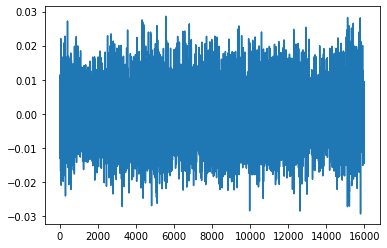

In [46]:
pred = model.predict(validate_dataset.take(1))[0]
# pred = model.predict(dataset_train.take(8))[0]

plt.plot(pred)
display(Audio(pred, rate=8000))

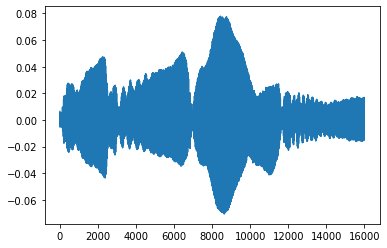

In [47]:
for x, y in validate_dataset.take(1):
  # print(type(y.shape[0]))
  # plt.imshow(x[:, :, 0], cmap="inferno")
  # plt.title(x.shape)
  # plt.show()
  # plt.close()
  # display(Audio(x, rate=8000))

  plt.plot(y[0])
  # plt.show()
  # plt.close()
  display(Audio(y[0], rate=8000))
  break
# t = dataset_train.take(2)
# t = next(t)[0].numpy().astype("float32")

# display(Audio(t, rate=8000))

In [41]:
n_labels = 8
model = models.Sequential([
    layers.Input((16000)),
    STFT(
        frame_length=255, 
        frame_step=128, 
        n_freqs=123, 
        frequency_trainable=False, 
        window_trainable=False, 
        freq_type='linspace', 
        window_type='hann',     
        out_module=False
    ),
    preprocessing.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16000),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['accuracy'],
)
EPOCHS = 10
history = model.fit(
    train_dataset, 
    validation_data=validate_dataset,   
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stft_25 (STFT)              (None, 123, 123, 2)       378       
                                                                 
 resizing_5 (Resizing)       (None, 32, 32, 2)         0         
                                                                 
 conv2d_118 (Conv2D)         (None, 30, 30, 32)        608       
                                                                 
 conv2d_119 (Conv2D)         (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 14, 14, 64)        0         
                                                     

KeyboardInterrupt: ignored